In [1]:
# Cell 1: Imports, paths, and load 4 core data files

import pandas as pd
import numpy as np
from pathlib import Path
import json

# 如果需要画图（后面 sensitivity 可以用）
import matplotlib.pyplot as plt

# 1) 路径设置（假设本 Notebook 和 brsb_data_generator.ipynb 在同一文件夹 Notebook1 下）
BASE_DIR = Path.cwd()
DATA_DIR = BASE_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"

print("BASE_DIR      :", BASE_DIR)
print("PROCESSED_DIR :", PROCESSED_DIR)

# 2) 读取四件套
nodes_path      = PROCESSED_DIR / "nodes.csv"
facilities_path = PROCESSED_DIR / "facilities.csv"
dist_path       = PROCESSED_DIR / "dist.csv"
scenarios_path  = PROCESSED_DIR / "scenarios.json"

nodes_df      = pd.read_csv(nodes_path)
facilities_df = pd.read_csv(facilities_path)
dist_df       = pd.read_csv(dist_path)

with open(scenarios_path, "r", encoding="utf-8") as f:
    scenarios = json.load(f)

print("\n[OK] Loaded files:")
print("nodes_df     :", nodes_df.shape)
print("facilities_df:", facilities_df.shape)
print("dist_df      :", dist_df.shape)
print("scenarios keys:", list(scenarios.keys()))

# 3) 简单清理：把节点和设施改成 index 方便后面建模
nodes_df = nodes_df.set_index("node_id")
facilities_df = facilities_df.set_index("facility_id")

# dist_df 的 index 已经是 node_id，列是 facility_id（如果不是，可以显式设置）
if "node_id" in dist_df.columns:
    dist_df = dist_df.set_index("node_id")

# 看一眼前几行，确认结构
display(nodes_df.head())
display(facilities_df.head())
display(dist_df.head())


BASE_DIR      : D:\Projects\llm_or_project\Notebook1
PROCESSED_DIR : D:\Projects\llm_or_project\Notebook1\data\processed

[OK] Loaded files:
nodes_df     : (5, 10)
facilities_df: (3, 13)
dist_df      : (5, 4)
scenarios keys: ['baseline', 'F01_40pct_5days', 'F02_80pct_10days', 'F03_60pct_7days']


,SA2_CODE,SA2_NAME,LAT,LON,POP,recycled_tonnes_total,grade_A_t,grade_B_t,grade_C_t
node_id,,,,,,,,,
N001,D01,Demo Area 1,-27.47,153.03,30000,97.573047,68.301133,24.393262,4.878652
N002,D02,Demo Area 2,-27.45,153.01,25000,81.310872,56.917611,20.327718,4.065544
N003,D03,Demo Area 3,-27.49,153.05,20000,65.048698,45.534089,16.262174,3.252435
N004,D04,Demo Area 4,-27.50,153.00,15000,48.786523,34.150566,12.196631,2.439326
N005,D05,Demo Area 5,-27.46,153.04,10000,32.524349,22.767044,8.131087,1.626217


,name,TYPE,LAT,LON,accept_A,accept_B,accept_C,capacity_total_t,cap_A_t,cap_B_t,cap_C_t,fixed_cost
facility_id,,,,,,,,,,,,
F01,Demo Recycling Center 1,recycling,-27.48,153.02,1,1,1,50.0,35.0,12.5,2.5,200
F02,Demo Remanufacturing Plant 1,remanufacturing,-27.44,153.04,1,1,0,30.0,21.0,7.5,0.0,250
F03,Demo Second-life Facility 1,second_life,-27.50,153.00,1,0,0,40.0,28.0,0.0,0.0,180


,F01,F02,F03
node_id,,,
N001,1783.800076,4174.462650,5351.186227
N002,4174.432191,3794.820600,6775.913505
N003,3793.614030,6775.932275,6066.694582
N004,3567.386172,9301.738135,0.000000
N005,3567.671441,2668.678239,7135.057557


In [2]:
# Cell 2: Define grade structure and high-level parameters

# 约定三个等级：A/B/C
GRADES = ["A", "B", "C"]

# 节点需求列名（来自 brsb_data_generator.ipynb）
GRADE_DEMAND_COL = {
    "A": "grade_A_t",
    "B": "grade_B_t",
    "C": "grade_C_t",
}

# 设施容量列名
GRADE_CAP_COL = {
    "A": "cap_A_t",
    "B": "cap_B_t",
    "C": "cap_C_t",
}

# 等级接受标记
ACCEPT_COL = {
    "A": "accept_A",
    "B": "accept_B",
    "C": "accept_C",
}

# 运输成本参数：每吨·公里的成本（可以在 sensitivity 部分调整）
TRANSPORT_COST_PER_TKM = {
    "A": 1.0,
    "B": 1.0,
    "C": 1.1,   # 假设危险性更高，稍贵一点
}

# 把 dist 的单位从 m 转成 km，用于成本计算
dist_km_df = dist_df.copy()
dist_km_df = dist_km_df.astype(float) / 1000.0

# 1) 计算总需求 & 总容量，检查模型是否可行
summary_rows = []
for g in GRADES:
    total_demand = nodes_df[GRADE_DEMAND_COL[g]].sum()
    total_capacity = facilities_df[GRADE_CAP_COL[g]].sum()
    summary_rows.append({
        "grade": g,
        "total_demand_t": total_demand,
        "total_capacity_t": total_capacity,
        "capacity_minus_demand": total_capacity - total_demand,
    })

system_summary = pd.DataFrame(summary_rows)
print("=== System demand vs capacity (baseline) ===")
display(system_summary)


=== System demand vs capacity (baseline) ===


,grade,total_demand_t,total_capacity_t,capacity_minus_demand
0,A,227.670443,84.0,-143.670443
1,B,81.310872,20.0,-61.310872
2,C,16.262174,2.5,-13.762174


In [3]:
# ============================================================
# A. Gurobi OR 模型：solve_bne_model + solve_or_for_scenario
# ============================================================

import gurobipy as gp
from gurobipy import Model, GRB, quicksum  # ✅ 加上 Model 和 quicksum

def solve_bne_model(capacity_factor, unmet_penalty, verbose=False):
    # -------- 0. 把 capacity_factor 统一变成 {facility_id: factor} 的 dict --------
    fac_ids = list(facilities_df.index)

    if capacity_factor is None:
        cap_factor = {fid: 1.0 for fid in fac_ids}
    elif isinstance(capacity_factor, (int, float)):
        cf = float(capacity_factor)
        cap_factor = {fid: cf for fid in fac_ids}
    elif isinstance(capacity_factor, dict):
        cap_factor = {fid: float(capacity_factor.get(fid, 1.0)) for fid in fac_ids}
    else:
        raise TypeError(
            f"capacity_factor must be None, float/int or dict, got {type(capacity_factor)}"
        )

    # -------- 1. 准备数据 --------
    node_ids = list(nodes_df.index)
    grades   = GRADES

    # 需求
    demand = {
        (i, g): float(nodes_df.loc[i, GRADE_DEMAND_COL[g]])
        for i in node_ids for g in grades
    }

    # 设施容量
    cap = {}
    for j in fac_ids:
        for g in grades:
            base_cap = float(facilities_df.loc[j, GRADE_CAP_COL[g]])
            accept   = int(facilities_df.loc[j, ACCEPT_COL[g]])
            eff_cap  = base_cap * cap_factor[j] * accept
            cap[(j, g)] = eff_cap

    # 距离
    dist_km = {(i, j): float(dist_df.loc[i, j]) for i in node_ids for j in fac_ids}
    trans_cost = TRANSPORT_COST_PER_TKM

    # -------- 2. 建模 --------
    m = Model("bne_llm_or")
    m.Params.OutputFlag = 1 if verbose else 0

    x = {}
    for i in node_ids:
        for j in fac_ids:
            for g in grades:
                x[(i, j, g)] = m.addVar(lb=0.0, name=f"x_{i}_{j}_{g}")

    u = {}
    for i in node_ids:
        for g in grades:
            u[(i, g)] = m.addVar(lb=0.0, name=f"u_{i}_{g}")

    m.update()

    # 约束 (a) 需求平衡
    for i in node_ids:
        for g in grades:
            m.addConstr(
                quicksum(x[(i, j, g)] for j in fac_ids) + u[(i, g)] == demand[(i, g)],
                name=f"demand_{i}_{g}"
            )

    # 约束 (b) 设施容量
    for j in fac_ids:
        for g in grades:
            if cap[(j, g)] > 0:
                m.addConstr(
                    quicksum(x[(i, j, g)] for i in node_ids) <= cap[(j, g)],
                    name=f"cap_{j}_{g}"
                )
            else:
                for i in node_ids:
                    m.addConstr(
                        x[(i, j, g)] == 0.0,
                        name=f"cap_zero_{i}_{j}_{g}"
                    )

    # 目标函数
    transport_term = quicksum(
        x[(i, j, g)] * dist_km[(i, j)] * trans_cost[g]
        for i in node_ids for j in fac_ids for g in grades
    )
    unmet_term = unmet_penalty * quicksum(u[(i, g)] for i in node_ids for g in grades)
    m.setObjective(transport_term + unmet_term, GRB.MINIMIZE)

    # 求解
    m.optimize()
    status = m.status
    total_cost = float(m.ObjVal) if status == GRB.OPTIMAL else None

    total_unmet = None
    if status == GRB.OPTIMAL:
        total_unmet = sum(u[(i, g)].X for i in node_ids for g in grades)

    # 利用率表
    util_rows = []
    if status == GRB.OPTIMAL:
        for j in fac_ids:
            for g in grades:
                flow  = sum(x[(i, j, g)].X for i in node_ids)
                cap_t = cap[(j, g)]
                util  = flow / cap_t if cap_t > 0 else 0.0
                util_rows.append({
                    "facility_id": j,
                    "grade": g,
                    "flow_t": flow,
                    "cap_t": cap_t,
                    "utilization": util,
                })
    util_df = pd.DataFrame(util_rows)

    return {
        "model": m,
        "status": status,
        "total_cost": total_cost,
        "total_unmet": total_unmet,
        "util_df": util_df,
    }


def solve_or_for_scenario(
    name: str,
    scenario_dict: dict,
    facilities_df,
    baseline_cost: float,
    scenario_type: str = "LLM_generated",
    verbose: bool = False,
):
    # 1) 从 dict 里取字段
    sid             = scenario_dict.get("scenario_id", name)
    summary_zh      = scenario_dict.get("summary_zh", "")
    affected_center = scenario_dict.get("affected_center", None)
    cap_factor      = float(scenario_dict.get("capacity_factor", 1.0))
    duration_days   = scenario_dict.get("duration_days", None)
    unmet_penalty   = float(scenario_dict.get("unmet_penalty", 10000.0))

    # 2) capacity_factor 映射
    fac_ids = list(facilities_df.index)
    cap_factor_dict = {fid: 1.0 for fid in fac_ids}
    if affected_center is not None:
        if affected_center not in fac_ids:
            raise RuntimeError(
                f"场景 {name} 中 affected_center={affected_center} 不在设施列表 {fac_ids} 中"
            )
        cap_factor_dict[affected_center] = cap_factor

    # 3) 调 OR 模型
    res = solve_bne_model(
        capacity_factor=cap_factor_dict,
        unmet_penalty=unmet_penalty,
        verbose=verbose,
    )

    total_cost  = res.get("total_cost", None)
    total_unmet = res.get("total_unmet", None)

    extra_cost = None
    if baseline_cost is not None and total_cost is not None:
        extra_cost = total_cost - baseline_cost

    avg_util = None
    util_df  = res.get("util_df", None)
    if isinstance(util_df, pd.DataFrame) and "utilization" in util_df.columns:
        avg_util = util_df["utilization"].mean()

    row = {
        "scenario_id": sid,
        "scenario_type": scenario_type,
        "summary_zh": summary_zh,
        "affected_center": affected_center,
        "capacity_factor": cap_factor,
        "duration_days": duration_days,
        "unmet_penalty": unmet_penalty,
        "total_cost": total_cost,
        "total_unmet_t": total_unmet,
        "extra_cost_vs_baseline": extra_cost,
        "avg_utilization": avg_util,
    }
    row_series = pd.Series(row, name=sid)
    return row_series, res


In [4]:
print("=== Solving baseline Brisbane battery-network model ===")

unmet_penalty_base = 10000

baseline_res = solve_bne_model(
    capacity_factor=1.0,          # baseline 不调整容量
    unmet_penalty=unmet_penalty_base,
    verbose=False,
)

print("Keys in baseline_res:", baseline_res.keys())

if baseline_res["status"] == GRB.OPTIMAL:
    baseline_cost  = baseline_res["total_cost"]
    baseline_unmet = baseline_res["total_unmet"]

    print(f"Baseline total cost: {baseline_cost:,.2f} AUD")
    print(f"Baseline unmet demand: {baseline_unmet:.4f} t")
else:
    raise RuntimeError(f"Baseline model not optimal, status={baseline_res['status']}")


=== Solving baseline Brisbane battery-network model ===
Set parameter Username
Set parameter LicenseID to value 2737110
Keys in baseline_res: dict_keys(['model', 'status', 'total_cost', 'total_unmet', 'util_df'])
Baseline total cost: 2,353,128.18 AUD
Baseline unmet demand: 218.7435 t


In [5]:
import json
import time
import numpy as np
import pandas as pd
from pathlib import Path

# 路径与常量：按你现有项目调整
PROJECT_ROOT   = Path("D:/Projects/llm_or_project/Notebook1")
PROCESSED_DIR  = PROJECT_ROOT / "data" / "processed"

FINAL_SUMMARY_CSV = PROCESSED_DIR / "tbl_experiment_summary_FINAL.csv"

print("使用的 FINAL CSV:", FINAL_SUMMARY_CSV)
exp_final = pd.read_csv(FINAL_SUMMARY_CSV)

print("\nFINAL 表 scenario_type 统计：")
print(exp_final["scenario_type"].value_counts())
print("\nFINAL 表 scenario_id 列表：")
print(exp_final["scenario_id"].tolist())
# ============================================================
# 0.x 读取设施表 + 公共 OR 求解函数（供 5.x 实验复用）
# ============================================================

# ---- 1) 读取设施表（与前面几个 Notebook 保持一致） ----
fac_path = PROCESSED_DIR / "facilities.csv"
facilities_df = pd.read_csv(fac_path).copy()

# 兼容不同列名：优先 facility_id / name，其次 FAC_ID / FAC_NAME
fac_id_col = "facility_id" if "facility_id" in facilities_df.columns else "FAC_ID"
facilities_df[fac_id_col] = facilities_df[fac_id_col].astype(str)
facilities_df = facilities_df.set_index(fac_id_col)

print("\n设施表已载入，设施 ID 列为:", fac_id_col)
print("设施列表:", list(facilities_df.index))

# ---- 2) 从 FINAL 表中取 baseline 成本（后面算 extra_cost 用） ----
def get_baseline_cost(df: pd.DataFrame) -> float:
    row = df[df["scenario_type"] == "baseline"].iloc[0]
    return float(row["total_cost"])

baseline_cost = get_baseline_cost(exp_final)
print(f"\nBaseline total_cost = {baseline_cost:,.2f} AUD")

# ---- 3) 公共 OR 求解函数：给一个场景 dict，返回一行 summary ----
def solve_or_for_scenario(
    name: str,
    scenario_dict: dict,
    facilities_df: pd.DataFrame,
    baseline_cost: float | None = None,
    scenario_type: str = "LLM_generated",
    verbose: bool = False,
):
    """
    给定一个场景参数 dict（来自 engineered 设计或 LLM 解析），调用 Gurobi 模型求解，
    返回：
        row_series: 一行带指标的 Series，可直接 append 到实验 DataFrame
        res:        solve_bne_model 的完整返回结果（含 util_df 等）
    
    期望 scenario_dict 至少包含：
        - affected_center: 受影响设施 ID（字符串）或 None
        - capacity_factor: 该设施容量缩放比例（float），缺省 = 1.0
        - duration_days:   场景持续天数（可选，仅记录用）
        - unmet_penalty:   未满足需求处罚成本（缺省 = 10000）
        - summary_zh:      中文摘要（可选）
        - scenario_id:     场景 ID（可选，不给的话用 name 替代）
    
    注意：
    - 假设 solve_bne_model(...) 已在前面的 Cell 中定义 / 导入（与实验 2、3 相同）。
    - facilities_df 的 index 必须是字符串形式的 facility_id。
    """

    # -------- 1) 从 dict 里安全地取字段 --------
    sid = scenario_dict.get("scenario_id", name)
    summary_zh = scenario_dict.get("summary_zh", "")
    affected_center = scenario_dict.get("affected_center", None)

    # 若 LLM / engineered 没给，就用 1.0 作为 capacity_factor
    cap_factor = float(scenario_dict.get("capacity_factor", 1.0))

    # 若没给 duration_days，就设 None，不影响 OR，只用来记在表里
    duration_days = scenario_dict.get("duration_days", None)

    # unmet_penalty：如果缺省，就沿用第二个实验的 10000
    unmet_penalty = float(scenario_dict.get("unmet_penalty", 10000))

    # -------- 2) 组装 capacity_factor 映射 --------
    fac_ids = list(facilities_df.index.astype(str))
    cap_factor_dict = {fid: 1.0 for fid in fac_ids}

    if affected_center is not None:
        affected_center = str(affected_center)
        if affected_center not in fac_ids:
            raise RuntimeError(
                f"场景 {name} 中的 affected_center='{affected_center}' 不在设施列表中：{fac_ids}"
            )
        cap_factor_dict[affected_center] = cap_factor

    # -------- 3) 调用 Gurobi 模型 --------
    # 这里假设你已经在本 Notebook 前面 from 某个模块导入了 solve_bne_model，
    # 或者直接把实验 2 里的 solve_bne_model 复制过来。
    res = solve_bne_model(
        capacity_factor=cap_factor_dict,
        unmet_penalty=unmet_penalty,
        verbose=verbose,
    )

    total_cost = res.get("total_cost", None)
    total_unmet = res.get("total_unmet", None)

    # -------- 4) 组装一行 summary（与实验 2 的表结构对齐） --------
    extra_cost = None
    if baseline_cost is not None and total_cost is not None:
        extra_cost = total_cost - baseline_cost

    # 计算平均利用率（整个网络所有设施的平均）
    avg_util = None
    util_df = res.get("util_df", None)
    if isinstance(util_df, pd.DataFrame) and "utilization" in util_df.columns:
        avg_util = util_df["utilization"].mean()

    row = {
        "scenario_id": sid,
        "scenario_type": scenario_type,        # 默认 'LLM_generated'，也可以传 'engineered_disruption'
        "summary_zh": summary_zh,
        "affected_center": affected_center,
        "capacity_factor": cap_factor,
        "duration_days": duration_days,
        "unmet_penalty": unmet_penalty,
        "total_cost": total_cost,
        "total_unmet_t": total_unmet,
        "extra_cost_vs_baseline": extra_cost,
        "avg_utilization": avg_util,
    }

    row_series = pd.Series(row, name=sid)
    return row_series, res


使用的 FINAL CSV: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_experiment_summary_FINAL.csv

FINAL 表 scenario_type 统计：
scenario_type
LLM_generated            6
engineered_disruption    5
baseline                 1
Name: count, dtype: int64

FINAL 表 scenario_id 列表：
['BASE', 'F01_120pct_14days', 'F01_40pct_5days', 'F01_60pct_5days', 'F02_50pct_3days', 'F03_40pct_3days', 'LLM_case_F01_40pct_7days', 'LLM_case_F01_60pct_7days', 'LLM_case_F02_40pct_10days', 'LLM_case_F02_60pct_10days', 'LLM_case_F03_60pct_7days', 'LLM_case_F03_80pct_7days']

设施表已载入，设施 ID 列为: facility_id
设施列表: ['F01', 'F02', 'F03']

Baseline total_cost = 2,353,128.18 AUD


In [6]:
# ========= 小工具：安全保存实验结果（与实验 2 保持一致） =========
import pandas as pd

def save_experiment_results(df: pd.DataFrame, filename: str):
    """
    将实验结果保存到 data/processed 下，避免误覆盖 FINAL 汇总表。
    """
    target = PROCESSED_DIR / filename   # PROCESSED_DIR 在 0 公共设置里已经定义好了

    # FINAL_SUMMARY_CSV 同样在 0 公共设置里定义过：
    # FINAL_SUMMARY_CSV = PROCESSED_DIR / "tbl_experiment_summary_FINAL.csv"
    if target.name == FINAL_SUMMARY_CSV.name:
        raise RuntimeError(
            "禁止覆盖 FINAL 实验汇总表，请改用其它文件名。"
        )

    df.to_csv(target, index=False, encoding="utf-8-sig")
    print(f"✅ 已保存结果到: {target}")


In [7]:
# ============================================================
# 5.1 LLM 输出稳定性实验：同一 prompt 多次调用
# ============================================================

import json
import math
import random
import pandas as pd
import matplotlib.pyplot as plt

# -------- 0) 选定要测试稳定性的 prompt --------
# 建议：使用你 FINAL 场景中已有的一个 LLM 场景对应的 prompt，
# 例如 "LLM_case_F01_40pct_7days" 那个。
#
# 如果你已经在本 notebook 里有 LLM_CASE_PROMPTS，可以这样：
# TEST_PROMPT = LLM_CASE_PROMPTS["LLM_case_prompt_1"]
#
# 否则就直接把那段 prompt 粘贴到下面这个三引号里：

TEST_SCENARIO_BASE_ID = "LLM_case_F01_40pct_7days"   # 仅用于生成 run 序号
TEST_PROMPT = """
        "scenario_id": "LLM_case_F01_40pct_7days",
        "summary_zh": "场景A：布里斯班 Demo Recycling Center 1（F01）未来7天只能以40%产能运行，其它设施保持正常。",
        "affected_center": "F01",
        "capacity_factor": 0.4,
        "duration_days": 7,
        "unmet_penalty": 10000
"""

# -------- 1) （可选）stub 版本的 LLM 调用，用于在没有真实 LLM 时跑通流程 --------
# 如果你已经从实验 3 拷贝了 call_llm_scenario，可以删掉这个 stub。

def call_llm_scenario(prompt: str, use_fake: bool = True) -> dict:
    """
    返回 dict: {"raw_text": "..."}。
    - use_fake=True 时，用一个固定 JSON + 小随机扰动来模拟 LLM 输出，便于在离线环境下测试流程。
    - 如果你要接入真实 LLM，把 use_fake=False 的分支改成你的调用代码即可。
    """
    if use_fake:
        # 基于 F01 40% 容量 7 天 的设定，做一点点随机抖动，模拟 LLM 的不稳定性
        base_cf = 0.4
        base_days = 7
        base_penalty = 10000

        cf = max(0.2, min(1.0, random.normalvariate(base_cf, 0.02)))
        days = max(3, min(14, int(round(random.normalvariate(base_days, 0.8)))))
        penalty = max(5000, min(20000, int(round(random.normalvariate(base_penalty, 800)))))

        fake_obj = {
            "scenario_id": TEST_SCENARIO_BASE_ID,
            "summary_zh": "模拟 LLM 输出：F01 容量约 40% 持续若干天。",
            "affected_center": "F01",
            "capacity_factor": round(cf, 3),
            "duration_days": int(days),
            "unmet_penalty": int(penalty),
        }
        raw_text = json.dumps(fake_obj, ensure_ascii=False, indent=2)
        return {"raw_text": raw_text}
    else:
        # TODO: 在这里写你真实的 LLM 调用逻辑，例如：
        #
        # resp = client.chat.completions.create(
        #     model="xxx",
        #     messages=[{"role": "user", "content": prompt}],
        #     temperature=0.2,
        # )
        # raw_text = resp.choices[0].message.content
        # return {"raw_text": raw_text}
        #
        raise NotImplementedError("请实现真实的 LLM 调用，或使用 use_fake=True 先测试流程。")

# -------- 2) 解析 LLM 输出为场景 dict --------

def simple_parse_llm_scenario_output(
    raw_text: str,
    default_unmet_penalty: float = 10000.0,
    max_capacity_factor: float = 1.5,
):
    """
    尝试从 LLM 的 raw_text 中解析出一个 JSON 场景对象。
    期望字段：
      - affected_center
      - capacity_factor
      - duration_days
      - unmet_penalty (可缺省)
      - scenario_id / summary_zh (可缺省)

    返回: (scenario_dict, parse_ok, err_msg)
    """
    raw_text = raw_text.strip()

    # 有的 LLM 会在 JSON 外面加解释文字，这里做个简单的“从第一个 { 到最后一个 }”截断
    if "{" in raw_text and "}" in raw_text:
        raw_text = raw_text[raw_text.find("{") : raw_text.rfind("}") + 1]

    try:
        obj = json.loads(raw_text)
    except Exception as e:
        return None, False, f"JSON 解析失败: {e}"

    # 基本字段检查
    affected_center = obj.get("affected_center", None)
    cf = obj.get("capacity_factor", None)
    dur = obj.get("duration_days", None)

    if affected_center is None or cf is None or dur is None:
        return None, False, "缺少关键字段（affected_center / capacity_factor / duration_days）"

    # 类型与范围简单清洗
    try:
        cf = float(cf)
    except Exception:
        return None, False, f"capacity_factor 不能转为 float: {cf}"

    if not math.isfinite(cf) or cf <= 0 or cf > max_capacity_factor:
        return None, False, f"capacity_factor 超出允许范围: {cf}"

    try:
        dur = int(dur)
    except Exception:
        return None, False, f"duration_days 不能转为 int: {dur}"

    if dur <= 0 or dur > 60:
        return None, False, f"duration_days 太小或太大: {dur}"

    penalty = obj.get("unmet_penalty", default_unmet_penalty)
    try:
        penalty = float(penalty)
    except Exception:
        penalty = default_unmet_penalty

    scen = {
        "scenario_id": obj.get("scenario_id", TEST_SCENARIO_BASE_ID),
        "summary_zh": obj.get("summary_zh", ""),
        "affected_center": affected_center,
        "capacity_factor": cf,
        "duration_days": dur,
        "unmet_penalty": penalty,
    }
    return scen, True, ""

# -------- 3) 主实验循环：对同一 prompt 调用 N 次 --------

N_RUNS = 20
use_fake_llm = True   # 先用模拟 LLM 跑通流程；接入真实 LLM 后改成 False

rows = []
fail_records = []

for k in range(N_RUNS):
    run_id = k + 1
    print(f"\n>>> 运行 {run_id}/{N_RUNS} ...")

    # 3.1 调用 LLM
    llm_res = call_llm_scenario(TEST_PROMPT, use_fake=use_fake_llm)
    raw_text = llm_res["raw_text"]

    # 3.2 解析 JSON → scenario_dict
    scen_dict, ok, err = simple_parse_llm_scenario_output(raw_text)

    if not ok:
        print(f"  解析失败：{err}")
        fail_records.append({"run_id": run_id, "error": err, "raw_text": raw_text[:200]})
        continue

    # 给每次运行一个唯一的 scenario_id
    scen_dict["scenario_id"] = f"{TEST_SCENARIO_BASE_ID}_run{run_id:02d}"

    # 3.3 调 OR 模型
    row_series, res = solve_or_for_scenario(
        name=scen_dict["scenario_id"],
        scenario_dict=scen_dict,
        facilities_df=facilities_df,
        baseline_cost=baseline_cost,
        scenario_type="LLM_generated",   # 也可以用 "LLM_stability" 区分
        verbose=False,
    )

    # 附加 run_id 方便分析
    row_series["run_id"] = run_id
    rows.append(row_series)

# 汇总成 DataFrame
if rows:
    stability_df = pd.DataFrame(rows).set_index("run_id").sort_index()
else:
    stability_df = pd.DataFrame()

print("\n=== 5.1 实验完成 ===")
print("总运行次数:", N_RUNS)
print("成功解析并求解的次数:", len(stability_df))
print("解析失败次数:", len(fail_records))

display(stability_df.head())



>>> 运行 1/20 ...

>>> 运行 2/20 ...

>>> 运行 3/20 ...

>>> 运行 4/20 ...

>>> 运行 5/20 ...

>>> 运行 6/20 ...

>>> 运行 7/20 ...

>>> 运行 8/20 ...

>>> 运行 9/20 ...

>>> 运行 10/20 ...

>>> 运行 11/20 ...

>>> 运行 12/20 ...

>>> 运行 13/20 ...

>>> 运行 14/20 ...

>>> 运行 15/20 ...

>>> 运行 16/20 ...

>>> 运行 17/20 ...

>>> 运行 18/20 ...

>>> 运行 19/20 ...

>>> 运行 20/20 ...

=== 5.1 实验完成 ===
总运行次数: 20
成功解析并求解的次数: 20
解析失败次数: 0


,scenario_id,scenario_type,summary_zh,affected_center,capacity_factor,duration_days,unmet_penalty,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization
run_id,,,,,,,,,,,
1,LLM_case_F01_40pct_7days_run01,LLM_generated,模拟 LLM 输出：F01 容量约 40% 持续若干天。,F01,0.415,7,9848.0,2.555496e+06,247.99349,202367.956601,0.666667
2,LLM_case_F01_40pct_7days_run02,LLM_generated,模拟 LLM 输出：F01 容量约 40% 持续若干天。,F01,0.397,8,10099.0,2.625218e+06,248.89349,272089.975331,0.666667
3,LLM_case_F01_40pct_7days_run03,LLM_generated,模拟 LLM 输出：F01 容量约 40% 持续若干天。,F01,0.400,6,9280.0,2.420251e+06,248.74349,67123.115181,0.666667
4,LLM_case_F01_40pct_7days_run04,LLM_generated,模拟 LLM 输出：F01 容量约 40% 持续若干天。,F01,0.403,6,10340.0,2.682637e+06,248.59349,329509.122056,0.666667
5,LLM_case_F01_40pct_7days_run05,LLM_generated,模拟 LLM 输出：F01 容量约 40% 持续若干天。,F01,0.394,8,9194.0,2.401080e+06,249.04349,47951.559350,0.666667


样本量: 20

关键字段描述统计：


,capacity_factor,duration_days,unmet_penalty,total_cost,total_unmet_t,extra_cost_vs_baseline
count,20.000000,20.000000,20.000000,2.000000e+01,20.000000,20.000000
mean,0.399550,7.100000,10062.850000,2.614917e+06,248.765990,261788.602363
std,0.016269,0.640723,785.074671,1.927366e+05,0.813452,192736.573495
min,0.371000,6.000000,8778.000000,2.299573e+06,246.943490,-53554.948062
25%,0.387500,7.000000,9638.500000,2.510322e+06,248.143490,157193.750320
50%,0.398500,7.000000,9966.000000,2.593860e+06,248.818490,240731.816453
75%,0.412000,7.250000,10658.500000,2.753827e+06,249.368490,400699.070674
max,0.436000,8.000000,11401.000000,2.961768e+06,250.193490,608640.064038


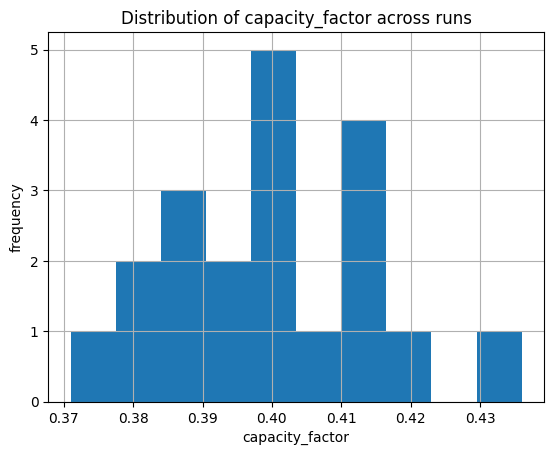

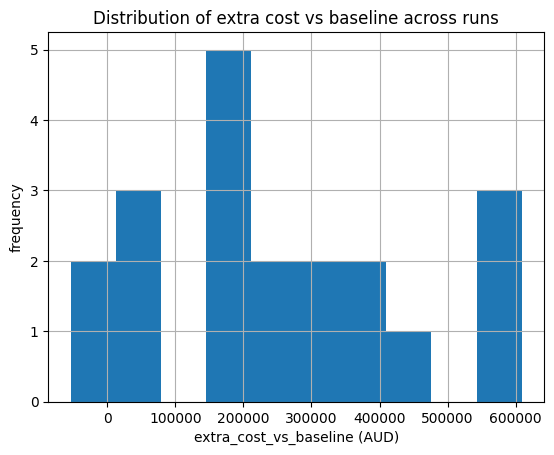

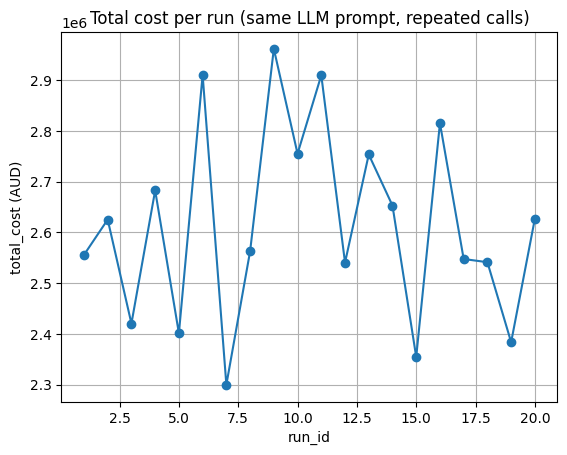

In [8]:
# ============================================================
# 5.1 结果分析：参数与成本波动
# ============================================================

if stability_df.empty:
    print("stability_df 为空，请先成功跑完 5.1 主实验循环。")
else:
    print("样本量:", len(stability_df))
    print("\n关键字段描述统计：")
    display(
        stability_df[
            ["capacity_factor", "duration_days", "unmet_penalty",
             "total_cost", "total_unmet_t", "extra_cost_vs_baseline"]
        ].describe()
    )

    if fail_records:
        print("\n解析失败样本数:", len(fail_records))
        print("前 3 个失败原因示例：")
        for rec in fail_records[:3]:
            print(f"  run {rec['run_id']}: {rec['error']}")

    # 1) capacity_factor 分布
    plt.figure()
    stability_df["capacity_factor"].hist(bins=10)
    plt.xlabel("capacity_factor")
    plt.ylabel("frequency")
    plt.title("Distribution of capacity_factor across runs")
    plt.show()

    # 2) extra_cost_vs_baseline 分布
    plt.figure()
    stability_df["extra_cost_vs_baseline"].hist(bins=10)
    plt.xlabel("extra_cost_vs_baseline (AUD)")
    plt.ylabel("frequency")
    plt.title("Distribution of extra cost vs baseline across runs")
    plt.show()

    # 3) run 序号 vs total_cost
    plt.figure()
    stability_df["total_cost"].plot(marker="o")
    plt.xlabel("run_id")
    plt.ylabel("total_cost (AUD)")
    plt.title("Total cost per run (same LLM prompt, repeated calls)")
    plt.grid(True)
    plt.show()


In [9]:
# ============================================================
# 5.2 Scenario generation methods: engineered vs random vs LLM
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) 选出终审里的 engineered / LLM 场景
eng_rows = exp_final[exp_final["scenario_type"] == "engineered_disruption"].copy()
llm_rows = exp_final[exp_final["scenario_type"] == "LLM_generated"].copy()

print("engineered 场景 ID:", eng_rows["scenario_id"].tolist())
print("LLM 场景 ID:", llm_rows["scenario_id"].tolist())

# 一个小工具：把 exp_final 里的一行，转成 solve_or_for_scenario 需要的 dict
def row_to_scenario_dict(row):
    return {
        "scenario_id":   row["scenario_id"],
        "summary_zh":    row.get("summary_zh", ""),
        "affected_center": row.get("affected_center", None),
        "capacity_factor": float(row.get("capacity_factor", 1.0)),
        "duration_days":   row.get("duration_days", None),
        "unmet_penalty": float(row.get("unmet_penalty", 10000.0)),
    }

def rerun_or_for_subset(sub_df):
    records = []
    for _, row in sub_df.iterrows():
        sc_dict = row_to_scenario_dict(row)
        s_type  = row["scenario_type"]
        row_series, res = solve_or_for_scenario(
            name=sc_dict["scenario_id"],
            scenario_dict=sc_dict,
            facilities_df=facilities_df,
            baseline_cost=baseline_cost,
            scenario_type=s_type,
            verbose=False,
        )
        records.append(row_series)
    return pd.DataFrame(records)

df_eng = rerun_or_for_subset(eng_rows)
df_llm = rerun_or_for_subset(llm_rows)

print("\nengineered 场景数:", len(df_eng))
print(df_eng[["scenario_id","capacity_factor","duration_days","extra_cost_vs_baseline"]])

print("\nLLM 场景数:", len(df_llm))
print(df_llm[["scenario_id","capacity_factor","duration_days","extra_cost_vs_baseline"]])


engineered 场景 ID: ['F01_120pct_14days', 'F01_40pct_5days', 'F01_60pct_5days', 'F02_50pct_3days', 'F03_40pct_3days']
LLM 场景 ID: ['LLM_case_F01_40pct_7days', 'LLM_case_F01_60pct_7days', 'LLM_case_F02_40pct_10days', 'LLM_case_F02_60pct_10days', 'LLM_case_F03_60pct_7days', 'LLM_case_F03_80pct_7days']

engineered 场景数: 5
                         scenario_id  capacity_factor  duration_days  \
F01_120pct_14days  F01_120pct_14days              1.2             14   
F01_40pct_5days      F01_40pct_5days              0.4              5   
F01_60pct_5days      F01_60pct_5days              0.6              5   
F02_50pct_3days      F02_50pct_3days              0.5              3   
F03_40pct_3days      F03_40pct_3days              0.4              3   

                   extra_cost_vs_baseline  
F01_120pct_14days           -8.207281e+04  
F01_40pct_5days              2.462184e+05  
F01_60pct_5days              1.641456e+05  
F02_50pct_3days              1.044713e+05  
F03_40pct_3days              2

In [10]:
# 2) 构造随机扰动场景 S_rand

rng = np.random.default_rng(42)
affected_centers = list(facilities_df.index)   # 比如 ['F01','F02','F03']

def generate_random_scenario(k, rng):
    center = rng.choice(affected_centers)

    # capacity 在 0.4~1.2 之间随机
    cap = float(rng.uniform(0.4, 1.2))

    # 持续天数 3~14 天之间的整数
    dur = int(rng.integers(3, 15))

    # penalty 在 8000~15000 间随机
    pen = float(rng.uniform(8000, 15000))

    scen_id = f"RAND_{center}_{int(cap*100):02d}pct_{dur}days_{k:02d}"

    sc_dict = {
        "scenario_id": scen_id,
        "summary_zh": f"随机场景：{center} 容量约 {cap:.2f}，持续 {dur} 天。",
        "affected_center": center,
        "capacity_factor": cap,
        "duration_days": dur,
        "unmet_penalty": pen,
    }
    return sc_dict

rand_records = []
N_rand = 20

for k in range(1, N_rand+1):
    sc_dict = generate_random_scenario(k, rng)
    row_series, res = solve_or_for_scenario(
        name=sc_dict["scenario_id"],
        scenario_dict=sc_dict,
        facilities_df=facilities_df,
        baseline_cost=baseline_cost,
        scenario_type="random_generated",
        verbose=False,
    )
    rand_records.append(row_series)

df_rand = pd.DataFrame(rand_records)

print("随机场景数:", len(df_rand))
df_rand.head()


随机场景数: 20


,scenario_id,scenario_type,summary_zh,affected_center,capacity_factor,duration_days,unmet_penalty,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization
RAND_F01_75pct_12days_01,RAND_F01_75pct_12days_01,random_generated,随机场景：F01 容量约 0.75，持续 12 天。,F01,0.751103,12,14010.185439,3.382375e+06,231.188352,1.029247e+06,0.666667
RAND_F01_47pct_11days_02,RAND_F01_47pct_11days_02,random_generated,随机场景：F01 容量约 0.48，持续 11 天。,F01,0.475342,11,14829.356461,3.751507e+06,244.976396,1.398379e+06,0.666667
RAND_F03_102pct_12days_03,RAND_F03_102pct_12days_03,random_generated,随机场景：F03 容量约 1.03，持续 12 天。,F03,1.028851,12,8896.795429,2.104622e+06,217.935649,-2.485060e+05,0.666667
RAND_F03_69pct_8days_04,RAND_F03_69pct_8days_04,random_generated,随机场景：F03 容量约 0.70，持续 8 天。,F03,0.696638,8,14487.354922,3.457765e+06,227.237614,1.104637e+06,0.666667
RAND_F03_105pct_10days_05,RAND_F03_105pct_10days_05,random_generated,随机场景：F03 容量约 1.06，持续 10 天。,F03,1.058209,10,11103.899392,2.576501e+06,217.113629,2.233730e+05,0.666667


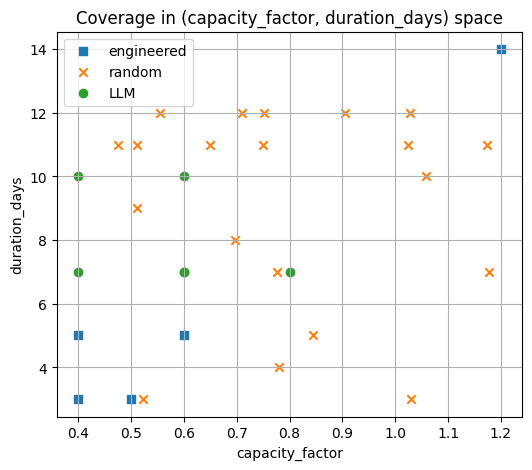

capacity_factor                                                    \
                     count      mean       std       min       25%       50%   
group                                                                          
LLM                    6.0  0.566667  0.150555  0.400000  0.450000  0.600000   
engineered             5.0  0.620000  0.334664  0.400000  0.400000  0.500000   
random                20.0  0.796621  0.226123  0.475342  0.626348  0.763374   

                              duration_days       ...               \
                75%       max         count mean  ...    75%   max   
group                                             ...                
LLM         0.60000  0.800000           6.0  8.0  ...   9.25  10.0   
engineered  0.60000  1.200000           5.0  6.0  ...   5.00  14.0   
random      1.02565  1.176558          20.0  9.1  ...  11.25  12.0   

           extra_cost_vs_baseline                                              \
                            count           mean           std            min   
group                                                                           
LLM                           6.0  902779.418181  9.209861e+05   56000.000000   
engineered                    5.0  591239.493681  1.086867e+06  -82072.809240   
random                       20.0  424349.823091  5.165401e+05 -314025.837088   

                                                                      
                      25%            50%           75%           max  
group                                                                 
LLM         184663.820789  740256.471984  1.287011e+06  2.411435e+06  
engineered  104471.335088  164145.618479  2.462184e+05  2.523435e+06  
random       -3195.742209  338271.181174  8.739855e+05  1.398379e+06  

[3 rows x 24 columns]

In [11]:
# 3) 覆盖度对比：capacity_factor vs duration_days

plt.figure(figsize=(6,5))
plt.scatter(df_eng["capacity_factor"], df_eng["duration_days"],
            marker="s", label="engineered")
plt.scatter(df_rand["capacity_factor"], df_rand["duration_days"],
            marker="x", label="random")
plt.scatter(df_llm["capacity_factor"], df_llm["duration_days"],
            marker="o", label="LLM")
plt.xlabel("capacity_factor")
plt.ylabel("duration_days")
plt.title("Coverage in (capacity_factor, duration_days) space")
plt.legend()
plt.grid(True)
plt.show()


# 4) 把三类场景拼成一个 summary_5_2（加上 group 列）
summary_5_2 = pd.concat(
    [
        df_eng.assign(group="engineered"),
        df_rand.assign(group="random"),
        df_llm.assign(group="LLM"),
    ],
    ignore_index=True,
)

# 看一眼
summary_5_2.head()

# 5) 三类场景的 summary 表（方便直接贴论文）
summary_stats_5_2 = (
    summary_5_2
    .groupby("group")[["capacity_factor",
                       "duration_days",
                       "extra_cost_vs_baseline"]]
    .describe()
)

summary_stats_5_2


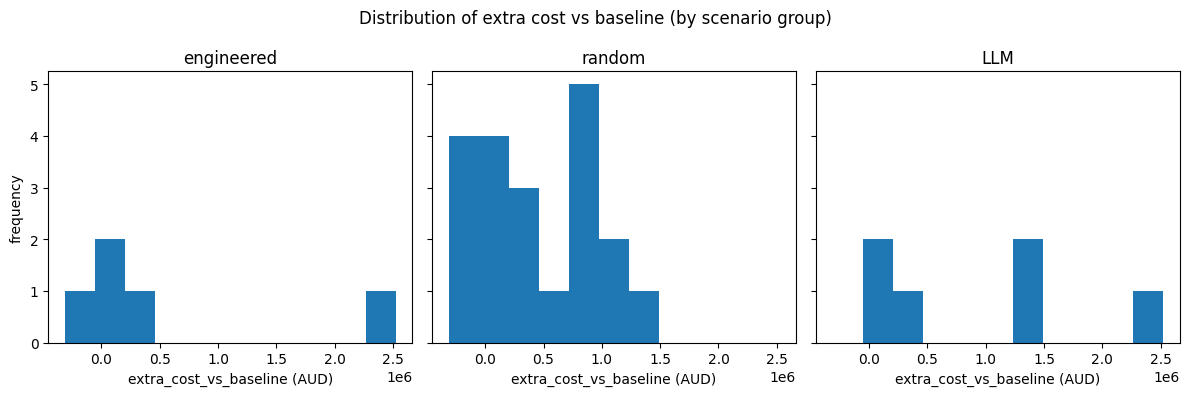

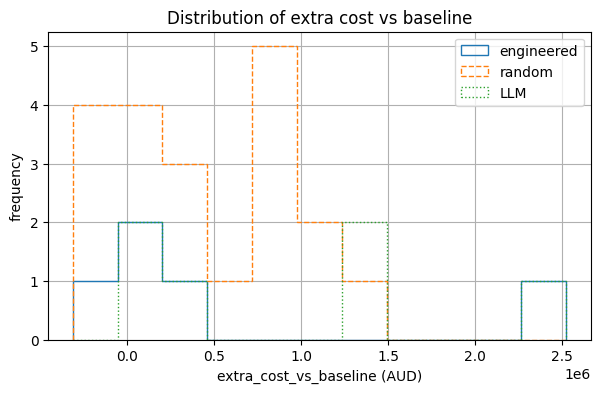

In [12]:
# 5) 经济影响分布：extra_cost_vs_baseline 直方图
import numpy as np
import matplotlib.pyplot as plt

# A为了可比性，用同一组 bins
all_extra = pd.concat([
    df_eng["extra_cost_vs_baseline"],
    df_rand["extra_cost_vs_baseline"],
    df_llm["extra_cost_vs_baseline"],
], ignore_index=True)

bins = np.linspace(all_extra.min(), all_extra.max(), 12)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].hist(df_eng["extra_cost_vs_baseline"], bins=bins)
axes[0].set_title("engineered")
axes[0].set_xlabel("extra_cost_vs_baseline (AUD)")
axes[0].set_ylabel("frequency")

axes[1].hist(df_rand["extra_cost_vs_baseline"], bins=bins)
axes[1].set_title("random")
axes[1].set_xlabel("extra_cost_vs_baseline (AUD)")

axes[2].hist(df_llm["extra_cost_vs_baseline"], bins=bins)
axes[2].set_title("LLM")
axes[2].set_xlabel("extra_cost_vs_baseline (AUD)")

fig.suptitle("Distribution of extra cost vs baseline (by scenario group)")
plt.tight_layout()
plt.show()

#B
all_extra = pd.concat([
    df_eng["extra_cost_vs_baseline"],
    df_rand["extra_cost_vs_baseline"],
    df_llm["extra_cost_vs_baseline"],
], ignore_index=True)

bins = np.linspace(all_extra.min(), all_extra.max(), 12)

plt.figure(figsize=(7, 4))

plt.hist(df_eng["extra_cost_vs_baseline"],
         bins=bins, histtype="step", label="engineered")
plt.hist(df_rand["extra_cost_vs_baseline"],
         bins=bins, histtype="step", linestyle="--", label="random")
plt.hist(df_llm["extra_cost_vs_baseline"],
         bins=bins, histtype="step", linestyle=":", label="LLM")

plt.xlabel("extra_cost_vs_baseline (AUD)")
plt.ylabel("frequency")
plt.title("Distribution of extra cost vs baseline")
plt.legend()
plt.grid(True)
plt.show()



In [19]:
# =========================
# 5.3 参数敏感性 / 鲁棒性分析
# =========================

# 1）从 FINAL CSV 中挑选几个代表场景
#    这里选：2 个 engineered + 3 个 LLM（你可以改）

BASE_PEN_SCENARIOS = [
    "F01_40pct_5days",
    "F03_40pct_3days",
    "LLM_case_F01_40pct_7days",
    "LLM_case_F02_60pct_10days",
    "LLM_case_F03_80pct_7days",
]

# 更宽的惩罚网格：从几乎不罚到超大惩罚
PENALTY_GRID = [0, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 30000, 50000]

print("代表场景 ID：", REP_SCEN_IDS)
print("Penalty 网格：", PENALTY_GRID)


代表场景 ID： ['F01_40pct_5days', 'F03_40pct_3days', 'LLM_case_F01_40pct_7days', 'LLM_case_F02_60pct_10days', 'LLM_case_F03_80pct_7days']
Penalty 网格： [0, 1000, 2500, 5000, 7500, 10000, 15000, 20000, 30000, 50000]


In [20]:
import copy

def make_scenario_dict_from_final(sid: str) -> dict:
    """
    给定一个 scenario_id，从 exp_final（FINAL 表）里取出该场景的
    capacity_factor / affected_center / duration_days 等信息，
    组装成 solve_or_for_scenario 可用的 dict（不含 penalty）。
    """
    # 找到这一行（假设 ID 唯一）
    row = exp_final.loc[exp_final["scenario_id"] == sid]
    if row.empty:
        raise ValueError(f"在 FINAL 表里找不到 scenario_id='{sid}'")

    row = row.iloc[0]

    scen_type = row.get("scenario_type", "engineered_disruption")
    scen_dict = {
        "scenario_id":     row["scenario_id"],
        "summary_zh":      row.get("summary_zh", ""),
        "affected_center": row.get("affected_center", None),
        "capacity_factor": row.get("capacity_factor", 1.0),
        "duration_days":   row.get("duration_days", None),
        # penalty 不在这里设置，在主循环里按 PENALTY_GRID 替换
    }
    return scen_dict, scen_type


# 小测试：看一眼两个代表场景
for sid in REP_SCEN_IDS[:2]:
    d, t = make_scenario_dict_from_final(sid)
    print("\nID:", sid, "type:", t)
    print(d)



ID: F01_40pct_5days type: engineered_disruption
{'scenario_id': 'F01_40pct_5days', 'summary_zh': '场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天处理能力降为40%。', 'affected_center': 'F01', 'capacity_factor': np.float64(0.4), 'duration_days': np.int64(5)}

ID: F03_40pct_3days type: engineered_disruption
{'scenario_id': 'F03_40pct_3days', 'summary_zh': '场景6：F03 因供应中断，未来3天可用容量仅为40%。', 'affected_center': 'F03', 'capacity_factor': np.float64(0.4), 'duration_days': np.int64(3)}


In [21]:
# =========================
# 主循环：对每个 (场景, penalty) 组合做敏感性分析
# =========================

records = []

for sid in REP_SCEN_IDS:
    base_sc_dict, scen_type_in_final = make_scenario_dict_from_final(sid)

    for pen in PENALTY_GRID:
        # 拷贝一份 dict，设置本轮 penalty
        scen_dict = copy.deepcopy(base_sc_dict)
        scen_dict["unmet_penalty"] = float(pen)

        # 给这次 run 起一个唯一名字，便于追踪
        run_name = f"{sid}_pen{pen}"

        # 这里用一个专门的 scenario_type，方便区分
        row_series, res = solve_or_for_scenario(
            name=run_name,
            scenario_dict=scen_dict,
            facilities_df=facilities_df,
            baseline_cost=baseline_cost,
            scenario_type="pen_sensitivity",
            verbose=False,
        )

        # 附加一些元信息：原始场景 ID、原始类型、当前 penalty
        row_series["base_scenario_id"] = sid
        row_series["base_scenario_type"] = scen_type_in_final
        row_series["unmet_penalty_grid"] = pen

        records.append(row_series)

print("总组合数：", len(records), "（应等于", len(REP_SCEN_IDS), "×", len(PENALTY_GRID), "）")

df_pen = pd.DataFrame(records)
df_pen.head()


总组合数： 50 （应等于 5 × 10 ）


,scenario_id,scenario_type,summary_zh,affected_center,capacity_factor,duration_days,unmet_penalty,total_cost,total_unmet_t,extra_cost_vs_baseline,avg_utilization,base_scenario_id,base_scenario_type,unmet_penalty_grid
F01_40pct_5days,F01_40pct_5days,pen_sensitivity,场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天...,F01,0.4,5,0.0,0.000000e+00,325.24349,-2.353128e+06,0.000000,F01_40pct_5days,engineered_disruption,0
F01_40pct_5days,F01_40pct_5days,pen_sensitivity,场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天...,F01,0.4,5,1000.0,2.972435e+05,297.24349,-2.055885e+06,0.111111,F01_40pct_5days,engineered_disruption,1000
F01_40pct_5days,F01_40pct_5days,pen_sensitivity,场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天...,F01,0.4,5,2500.0,7.289631e+05,277.24349,-1.624165e+06,0.444444,F01_40pct_5days,engineered_disruption,2500
F01_40pct_5days,F01_40pct_5days,pen_sensitivity,场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天...,F01,0.4,5,5000.0,1.355629e+06,248.74349,-9.974990e+05,0.666667,F01_40pct_5days,engineered_disruption,5000
F01_40pct_5days,F01_40pct_5days,pen_sensitivity,场景1：设施 Demo Recycling Center 1 (F01) 发生故障，未来5天...,F01,0.4,5,7500.0,1.977488e+06,248.74349,-3.756403e+05,0.666667,F01_40pct_5days,engineered_disruption,7500


In [22]:
# 1）检查每个 base 场景是否都有 4 个 penalty 结果
print("\n每个代表场景的运行次数：")
print(df_pen.groupby("base_scenario_id")["unmet_penalty_grid"].count())

# 2）简单看看 penalty 对 total_unmet_t / total_cost 的影响
print("\n按场景分组的 penalty 敏感性概览：")
display(
    df_pen[[
        "base_scenario_id",
        "unmet_penalty_grid",
        "total_unmet_t",
        "total_cost",
        "extra_cost_vs_baseline",
    ]].sort_values(["base_scenario_id", "unmet_penalty_grid"])
)

# 3）保存结果（避免覆盖 FINAL 表）
save_experiment_results(
    df_pen,
    "tbl_penalty_sensitivity_results.csv"
)



每个代表场景的运行次数：
base_scenario_id
F01_40pct_5days              10
F03_40pct_3days              10
LLM_case_F01_40pct_7days     10
LLM_case_F02_60pct_10days    10
LLM_case_F03_80pct_7days     10
Name: unmet_penalty_grid, dtype: int64

按场景分组的 penalty 敏感性概览：


,base_scenario_id,unmet_penalty_grid,total_unmet_t,total_cost,extra_cost_vs_baseline
F01_40pct_5days,F01_40pct_5days,0,325.24349,0.000000e+00,-2.353128e+06
F01_40pct_5days,F01_40pct_5days,1000,297.24349,2.972435e+05,-2.055885e+06
F01_40pct_5days,F01_40pct_5days,2500,277.24349,7.289631e+05,-1.624165e+06
F01_40pct_5days,F01_40pct_5days,5000,248.74349,1.355629e+06,-9.974990e+05
F01_40pct_5days,F01_40pct_5days,7500,248.74349,1.977488e+06,-3.756403e+05
F01_40pct_5days,F01_40pct_5days,10000,248.74349,2.599347e+06,2.462184e+05
F01_40pct_5days,F01_40pct_5days,15000,248.74349,3.843064e+06,1.489936e+06
F01_40pct_5days,F01_40pct_5days,20000,248.74349,5.086782e+06,2.733653e+06
F01_40pct_5days,F01_40pct_5days,30000,248.74349,7.574216e+06,5.221088e+06
F01_40pct_5days,F01_40pct_5days,50000,248.74349,1.254909e+07,1.019596e+07


✅ 已保存结果到: D:\Projects\llm_or_project\Notebook1\data\processed\tbl_penalty_sensitivity_results.csv


D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Projects\llm_or_project\llm_or_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26223

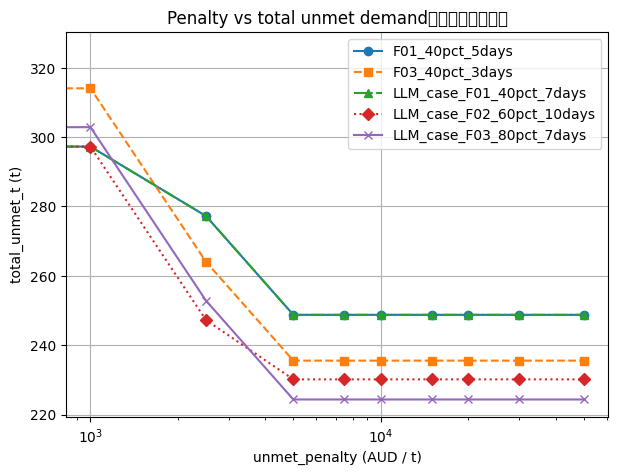

In [24]:
#5.3.5 画曲线
# =========================
# 5.3.5.1 惩罚 VS 未满足量（t）
# =========================
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))

styles = [
    ("o", "-"),   # 圆点 + 实线
    ("s", "--"),  # 方块 + 虚线
    ("^", "-."),  # 三角 + 点划线
    ("D", ":"),   # 菱形 + 点线
    ("x", "-"),   # 叉号 + 实线
]

for (base_id, sub), (marker, ls) in zip(df_pen.groupby("base_scenario_id"), styles):
    sub = sub.sort_values("unmet_penalty_grid")
    plt.plot(
        sub["unmet_penalty_grid"],
        sub["total_unmet_t"],
        marker=marker,
        linestyle=ls,
        label=base_id,
    )

plt.xlabel("unmet_penalty (AUD / t)")
plt.ylabel("total_unmet_t (t)")
plt.title("Penalty vs total unmet demand（代表场景对比）")
plt.xscale("log")
plt.grid(True)
plt.legend()
plt.show()



C:\Users\LiXu0\AppData\Local\Temp\ipykernel_16128\1891795987.py:50: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_16128\1891795987.py:50: UserWarning: Glyph 34920 (\N{CJK UNIFIED IDEOGRAPH-8868}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_16128\1891795987.py:50: UserWarning: Glyph 22330 (\N{CJK UNIFIED IDEOGRAPH-573A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_16128\1891795987.py:50: UserWarning: Glyph 26223 (\N{CJK UNIFIED IDEOGRAPH-666F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_16128\1891795987.py:50: UserWarning: Glyph 25935 (\N{CJK UNIFIED IDEOGRAPH-654F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\LiXu0\AppData\Local\Temp\ipykernel_16128\1891795987.py:50: UserWarning: Glyph 24863 (\

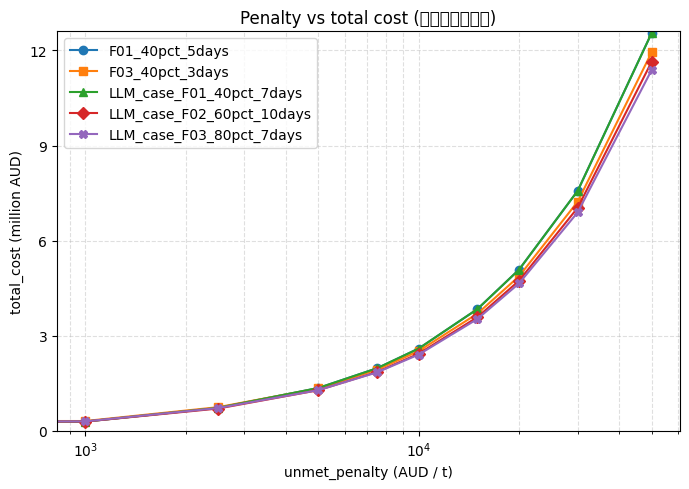

In [44]:
#5.3.2 penalty vs 总成本
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有 df_pen_sorted 和 unique_base_ids
# df_pen_sorted 里有：base_scenario_id, unmet_penalty_grid, total_cost 等列

plt.figure(figsize=(7, 5))

markers = ["o", "s", "^", "D", "X"]  # 五种不同 marker
colors  = ["C0", "C1", "C2", "C3", "C4"]

for idx, sid in enumerate(unique_base_ids):
    sub = df_pen_sorted[df_pen_sorted["base_scenario_id"] == sid].copy()

    # 1) 把 cost 转成 “million AUD”
    sub["total_cost_million"] = sub["total_cost"] / 1e6

    plt.plot(
        sub["unmet_penalty_grid"],
        sub["total_cost_million"],
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        linestyle="-",
        label=sid,
    )

# 2) x 轴用 log，让 5k~50k 看起来更舒服
plt.xscale("log")

# 3) 手动设置 y 轴范围 & 刻度（这里以 1M 为步长，你可以按需要改）
ymin = df_pen_sorted["total_cost"].min() / 1e6
ymax = df_pen_sorted["total_cost"].max() / 1e6

# 稍微留一点上下边距
ymin = np.floor(ymin * 10) / 10.0  # 向下取到 0.1 的倍数
ymax = np.ceil(ymax * 10) / 10.0   # 向上取到 0.1 的倍数

plt.ylim(ymin, ymax)

# 每 1 百万一个主刻度（如果区间太大，你可以改成 2 或 3）
yticks = np.arange(np.floor(ymin), np.ceil(ymax) + 0.3, 3.0)
plt.yticks(yticks)

plt.xlabel("unmet_penalty (AUD / t)")
plt.ylabel("total_cost (million AUD)")
plt.title("Penalty vs total cost (代表场景敏感性)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


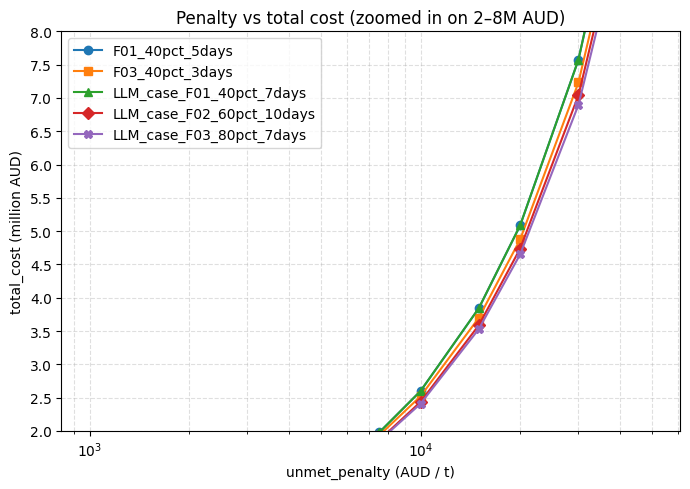

In [45]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 5))

markers = ["o", "s", "^", "D", "X"]
colors  = ["C0", "C1", "C2", "C3", "C4"]

for idx, sid in enumerate(unique_base_ids):
    sub = df_pen_sorted[df_pen_sorted["base_scenario_id"] == sid].copy()
    sub["total_cost_million"] = sub["total_cost"] / 1e6

    plt.plot(
        sub["unmet_penalty_grid"],
        sub["total_cost_million"],
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        linestyle="-",
        label=sid,
    )

plt.xscale("log")

# 🔍 只看 2 ~ 8 million 这段：曲线会明显“拉开”
plt.ylim(2, 8)

# 每 0.5M 一个刻度（你可以改成 1.0、0.25 等）
yticks = np.arange(2, 8.1, 0.5)
plt.yticks(yticks)

plt.xlabel("unmet_penalty (AUD / t)")
plt.ylabel("total_cost (million AUD)")
plt.title("Penalty vs total cost (zoomed in on 2–8M AUD)")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()


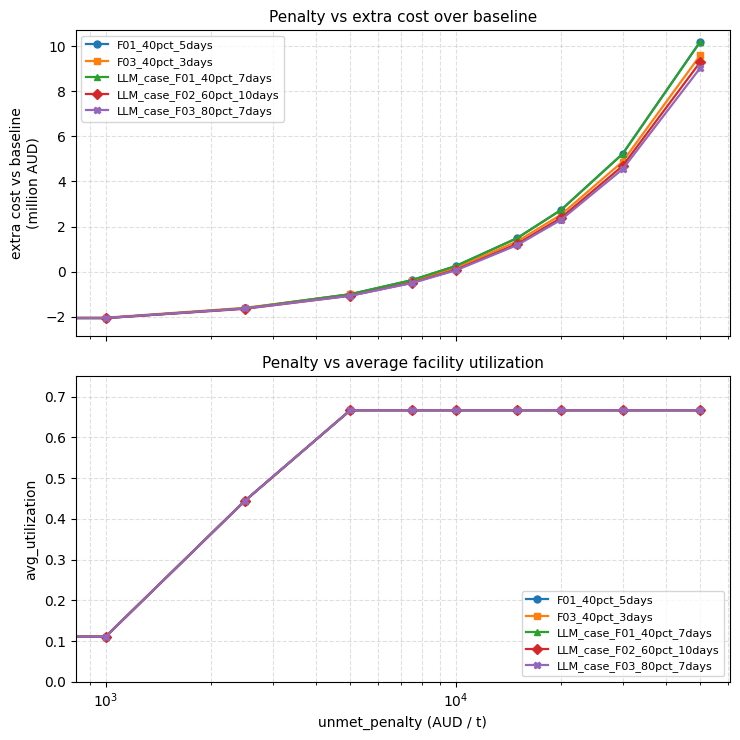

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# 假设已有：
# df_pen_sorted （包含 base_scenario_id, unmet_penalty_grid,
#                extra_cost_vs_baseline, avg_utilization 等列）
# unique_base_ids = df_pen_sorted["base_scenario_id"].unique()

fig, axes = plt.subplots(
    2, 1,
    figsize=(7.5, 7.5),   # 比之前稍大一点
    sharex=True
)

ax1, ax2 = axes

markers = ["o", "s", "^", "D", "X"]
colors  = ["C0", "C1", "C2", "C3", "C4"]

# -------- 1) Penalty vs extra_cost_vs_baseline（上图） --------
for idx, sid in enumerate(unique_base_ids):
    sub = df_pen_sorted[df_pen_sorted["base_scenario_id"] == sid].copy()
    sub = sub.sort_values("unmet_penalty_grid")

    # extra cost 用 million AUD 表示，数值更友好
    y_extra_m = sub["extra_cost_vs_baseline"] / 1e6

    ax1.plot(
        sub["unmet_penalty_grid"],
        y_extra_m,
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        linestyle="-",
        linewidth=1.6,
        markersize=5,
        label=sid,
    )

ax1.set_xscale("log")
ax1.set_ylabel("extra cost vs baseline\n(million AUD)")
ax1.set_title("Penalty vs extra cost over baseline", fontsize=11)

# 适当压缩纵轴范围，只保留有信息的区间
ymin = (df_pen_sorted["extra_cost_vs_baseline"].min() / 1e6) - 0.5
ymax = (df_pen_sorted["extra_cost_vs_baseline"].max() / 1e6) + 0.5
ax1.set_ylim(ymin, ymax)

ax1.grid(True, which="both", linestyle="--", alpha=0.4)
ax1.legend(loc="upper left", fontsize=8, ncol=1, frameon=True)


# -------- 2) Penalty vs avg_utilization（下图） --------
for idx, sid in enumerate(unique_base_ids):
    sub = df_pen_sorted[df_pen_sorted["base_scenario_id"] == sid].copy()
    sub = sub.sort_values("unmet_penalty_grid")

    ax2.plot(
        sub["unmet_penalty_grid"],
        sub["avg_utilization"],
        marker=markers[idx % len(markers)],
        color=colors[idx % len(colors)],
        linestyle="-",
        linewidth=1.6,
        markersize=5,
        label=sid,
    )

ax2.set_xscale("log")
ax2.set_xlabel("unmet_penalty (AUD / t)")
ax2.set_ylabel("avg_utilization")
ax2.set_title("Penalty vs average facility utilization", fontsize=11)

# 把 y 范围压到 0–0.75，细一点的刻度
ax2.set_ylim(0.0, 0.75)
ax2.set_yticks(np.arange(0.0, 0.8, 0.1))

ax2.grid(True, which="both", linestyle="--", alpha=0.4)
ax2.legend(loc="lower right", fontsize=8, frameon=True)

plt.tight_layout()
plt.show()


In [50]:
# ============================================================
# 5.4 Network size vs solve time（可扩展性实验）
# ============================================================

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 5.4.1 辅助函数：复制节点，放大网络 ----------
def make_scaled_network(nodes_base: pd.DataFrame,
                        dist_base: pd.DataFrame,
                        scale_factor: int):
    """
    把原始 nodes_df / dist_df 复制 scale_factor 份，用不同后缀区分 index。
    - 列结构保持不变
    - 设施数量保持不变
    - 目的只是把网络规模放大，方便做求解时间对比
    """
    if scale_factor == 1:
        return nodes_base.copy(), dist_base.copy()
    
    nodes_list = []
    dist_list = []
    
    for k in range(scale_factor):
        suffix = f"_s{k+1}"
        
        # 复制节点表
        tmp_nodes = nodes_base.copy()
        tmp_nodes.index = [f"{idx}{suffix}" for idx in nodes_base.index]
        nodes_list.append(tmp_nodes)
        
        # 复制距离表（行 = 节点）
        tmp_dist = dist_base.copy()
        tmp_dist.index = [f"{idx}{suffix}" for idx in dist_base.index]
        dist_list.append(tmp_dist)
    
    nodes_big = pd.concat(nodes_list, axis=0)
    dist_big  = pd.concat(dist_list, axis=0)
    
    return nodes_big, dist_big


# ---------- 5.4.2 在放大网络上调用 OR 模型并计时 ----------
def solve_scaled_network(scale_factor: int,
                         unmet_penalty: float):
    """
    1) 构造放大后的 nodes_df / dist_df
    2) 暂时替换全局 nodes_df / dist_df
    3) 调用 solve_bne_model（与 5.1–5.3 完全一致）
    4) 记录 Gurobi 求解时间、变量数量、结果指标
    5) 再恢复全局 nodes_df / dist_df
    """
    global nodes_df, dist_df  # 使用你在 0 公共设置里载入的全局变量
    
    # 备份原始数据
    nodes_orig = nodes_df
    dist_orig  = dist_df
    
    # 构造放大网络
    nodes_big, dist_big = make_scaled_network(nodes_orig, dist_orig, scale_factor)
    
    # 一些统计信息
    num_nodes = len(nodes_big)
    num_fac   = len(facilities_df)   # 设施表同样来自 0 公共设置
    num_grades = len(GRADES)
    num_x_vars = num_nodes * num_fac * num_grades
    num_u_vars = num_nodes * num_grades
    
    # 用放大网络临时替换全局
    nodes_df = nodes_big
    dist_df  = dist_big
    
    try:
        t0 = time.perf_counter()
        res = solve_bne_model(
            capacity_factor=1.0,          # 全部设施容量不缩放
            unmet_penalty=unmet_penalty,
            verbose=False
        )
        t1 = time.perf_counter()
    finally:
        # 不管成败，都恢复全局变量
        nodes_df = nodes_orig
        dist_df  = dist_orig
    
    runtime_sec = t1 - t0
    
    # 提取结果
    status      = res.get("status", None)
    total_cost  = res.get("total_cost", None)
    total_unmet = res.get("total_unmet", None)
    
    record = {
        "scale_factor": scale_factor,
        "num_nodes": num_nodes,
        "num_facilities": num_fac,
        "num_grades": num_grades,
        "num_x_vars": num_x_vars,
        "num_u_vars": num_u_vars,
        "solve_status": status,
        "solve_time_sec": runtime_sec,
        "total_cost": total_cost,
        "total_unmet_t": total_unmet,
    }
    return record


# ---------- 5.4.3 跑多组 scale，生成结果表 ----------
# 你可以根据运行速度调整这个列表，比如先尝试 [1, 2, 4, 8]
scale_list = [1, 2, 4, 8, 16]

records = []
for sf in scale_list:
    print(f"\n=== Running scale_factor = {sf} ===")
    rec = solve_scaled_network(scale_factor=sf, unmet_penalty=unmet_penalty_base)
    print(f"  status = {rec['solve_status']}, "
          f"time = {rec['solve_time_sec']:.3f} sec, "
          f"nodes = {rec['num_nodes']}, x-vars = {rec['num_x_vars']}")
    records.append(rec)

df_scale = pd.DataFrame(records)
df_scale



=== Running scale_factor = 1 ===
  status = 2, time = 0.010 sec, nodes = 5, x-vars = 45

=== Running scale_factor = 2 ===
  status = 2, time = 0.004 sec, nodes = 10, x-vars = 90

=== Running scale_factor = 4 ===
  status = 2, time = 0.009 sec, nodes = 20, x-vars = 180

=== Running scale_factor = 8 ===
  status = 2, time = 0.011 sec, nodes = 40, x-vars = 360

=== Running scale_factor = 16 ===
  status = 2, time = 0.022 sec, nodes = 80, x-vars = 720


,scale_factor,num_nodes,num_facilities,num_grades,num_x_vars,num_u_vars,solve_status,solve_time_sec,total_cost,total_unmet_t
0,1,5,3,3,45,15,2,0.009756,2.353128e+06,218.743490
1,2,10,3,3,90,30,2,0.003988,5.605563e+06,543.986979
2,4,20,3,3,180,60,2,0.009051,1.211043e+07,1194.473959
3,8,40,3,3,360,120,2,0.011213,2.512017e+07,2495.447917
4,16,80,3,3,720,240,2,0.022152,5.113965e+07,5097.395834


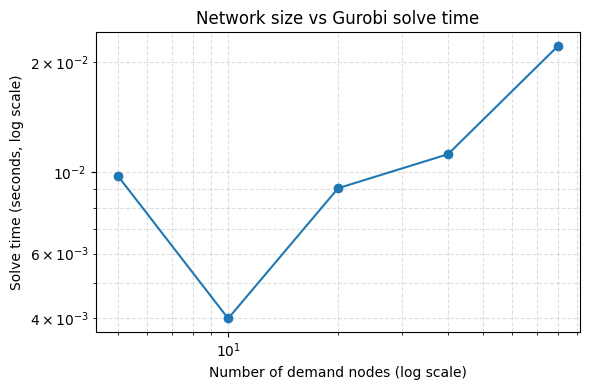

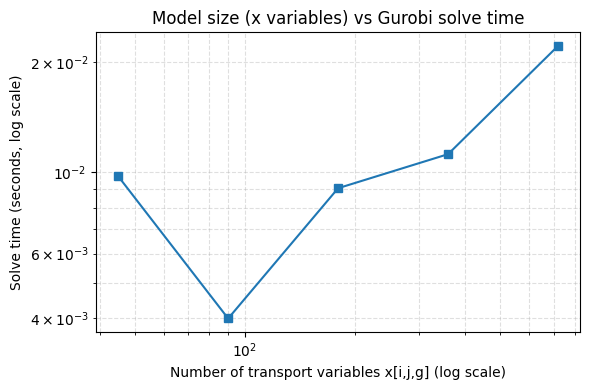

In [51]:
# ---------- 5.4.4 画图：规模 vs 求解时间 ----------

plt.figure(figsize=(6, 4))

# 1) 以节点数为横轴
plt.plot(
    df_scale["num_nodes"],
    df_scale["solve_time_sec"],
    marker="o"
)

plt.xscale("log")
plt.yscale("log")   # 可选：log-log，看曲线是否近似线性

plt.xlabel("Number of demand nodes (log scale)")
plt.ylabel("Solve time (seconds, log scale)")
plt.title("Network size vs Gurobi solve time")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# 可选：再画一张 “x 变量数 vs 求解时间”，更贴近理论复杂度
plt.figure(figsize=(6, 4))
plt.plot(
    df_scale["num_x_vars"],
    df_scale["solve_time_sec"],
    marker="s"
)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of transport variables x[i,j,g] (log scale)")
plt.ylabel("Solve time (seconds, log scale)")
plt.title("Model size (x variables) vs Gurobi solve time")
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
